In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val/tungro/102416.jpg
/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val/tungro/107860.jpg
/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val/tungro/100886.jpg
/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val/tungro/107034.jpg
/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val/tungro/103696.jpg
/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val/tungro/104381.jpg
/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val/tungro/108547.jpg
/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val/tungro/100535.jpg
/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val/tungro/110328.jpg
/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val/tungro/105992.jpg
/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val/tungro/105463.jpg
/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val/tungro/100014.jpg
/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val/tungro/106970.jpg

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Classes found: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'rice_sheath_blight', 'smut', 'tungro']
Number of classes: 12
bacterial_leaf_blight: 288 images
bacterial_leaf_streak: 378 images
bacterial_panicle_blight: 203 images
blast: 1044 images
brown_spot: 579 images
dead_heart: 866 images
downy_mildew: 372 images
hispa: 957 images
normal: 1059 images
rice_sheath_blight: 152 images
smut: 225 images
tungro: 654 images


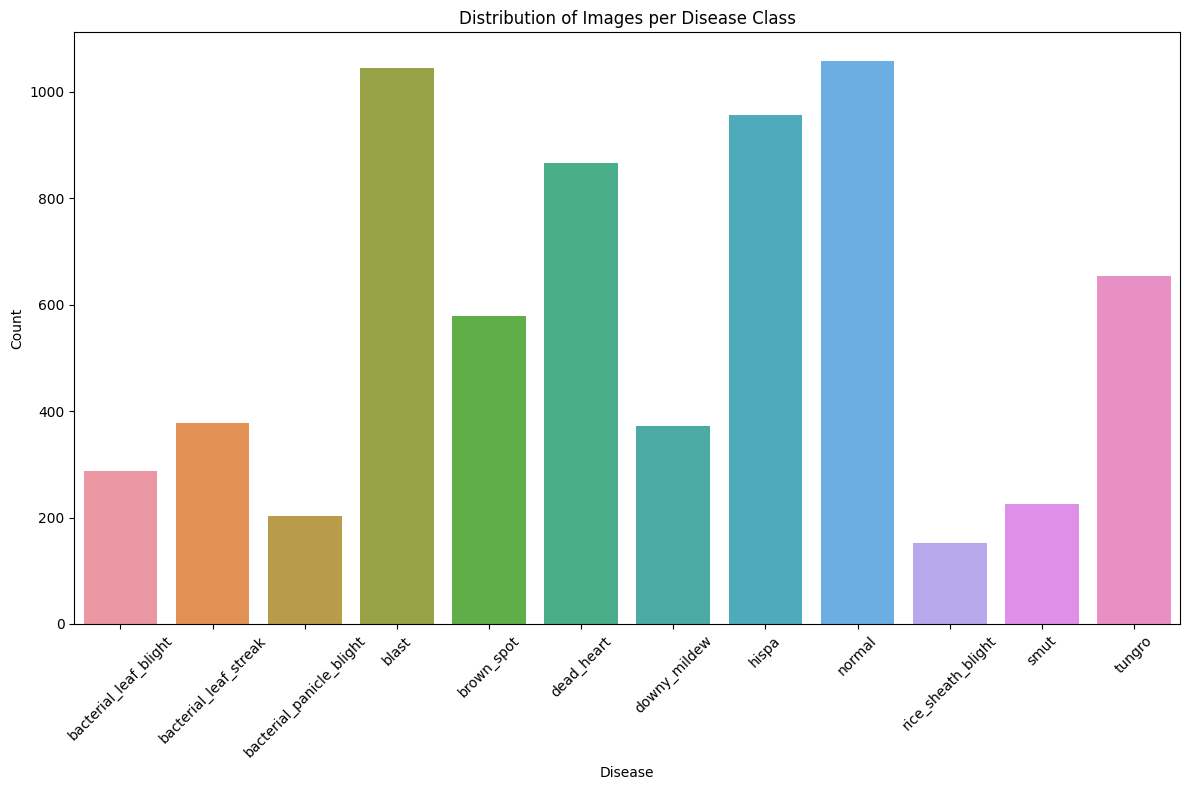

In [4]:
# Define the data paths
train_dir = '/kaggle/input/rice-leaf-diseases/rice_disease_val_test/train'
val_dir = '/kaggle/input/rice-leaf-diseases/rice_disease_val_test/val'

# Get class names
class_names = []
if os.path.exists(train_dir):
    class_names = sorted(os.listdir(train_dir))
print(f"Classes found: {class_names}")
print(f"Number of classes: {len(class_names)}")

# Count images in each class
class_counts = {}
for class_name in class_names:
    train_class_dir = os.path.join(train_dir, class_name)
    if os.path.exists(train_class_dir):
        count = len(os.listdir(train_class_dir))
        class_counts[class_name] = count
        print(f"{class_name}: {count} images")

# Create a DataFrame for visualization
df = pd.DataFrame(list(class_counts.items()), columns=['Disease', 'Count'])
plt.figure(figsize=(12, 8))
plt.xticks(rotation=45)
sns.barplot(data=df, x='Disease', y='Count')
plt.title('Distribution of Images per Disease Class')
plt.tight_layout()
plt.show()

In [5]:
class RiceDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((os.path.join(class_dir, img_name), self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [11]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = RiceDiseaseDataset(train_dir, transform=train_transform)
val_dataset = RiceDiseaseDataset(val_dir, transform=val_transform)

# Create data loaders (batch size 16 as per paper)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")

Training samples: 6777
Validation samples: 2254
Number of classes: 12
Classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'rice_sheath_blight', 'smut', 'tungro']


In [12]:
def get_model(model_name, num_classes, pretrained=True):
    """
    Get model based on name with optional pretrained weights
    """
    if model_name == 'densenet':
        model = models.densenet121(pretrained=pretrained)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == 'regnet':
        model = models.regnet_y_400mf(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'shufflenet_v2':
        model = models.shufflenet_v2_x0_5(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError(f"Model {model_name} not supported")
    
    return model

In [13]:
def count_parameters(model):
    """Count the number of trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.0001):
    """
    Train the model as per paper specifications
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Lists to store metrics
    train_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.2f}%')

    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_accuracies

In [15]:
def evaluate_model(model, test_loader, class_names):

    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1:.3f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': all_predictions,
        'labels': all_labels
    }

In [18]:
def plot_confusion_matrix(labels, predictions, class_names):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cm


Training RegNet with pretrained weights (Transfer Learning)


Downloading: "https://download.pytorch.org/models/regnet_y_400mf-c65dace8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-c65dace8.pth
100%|██████████| 16.8M/16.8M [00:00<00:00, 108MB/s] 


Parameters: 3.91M
Epoch [1/20], Loss: 1.4383, Val Acc: 76.13%
Epoch [10/20], Loss: 0.1077, Val Acc: 95.30%
Epoch [20/20], Loss: 0.0511, Val Acc: 95.34%
Accuracy: 0.953
Precision: 0.954
Recall: 0.953
F1-score: 0.953

Confusion Matrix for RegNet (with transfer learning):


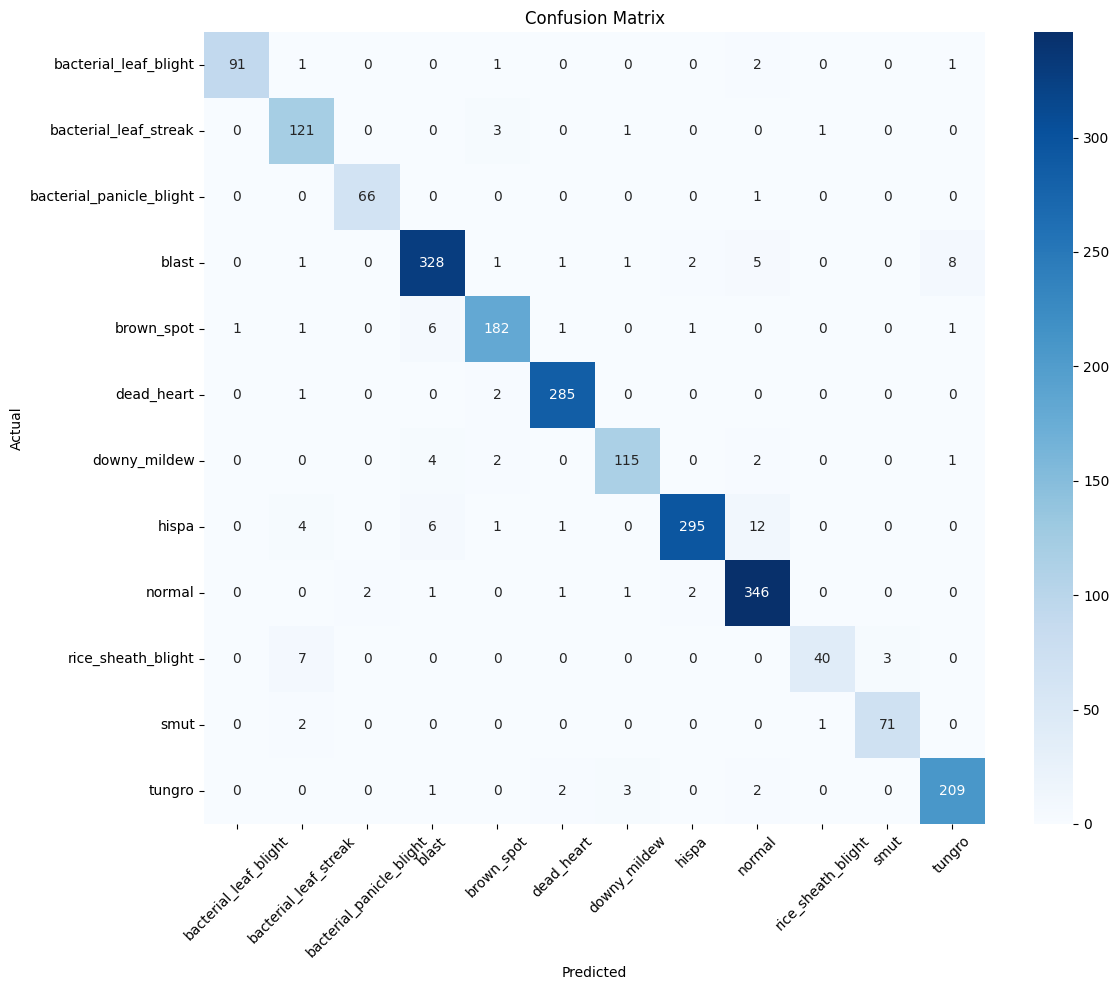


REGNET RESULTS WITH PRETRAINED WEIGHTS
 Model  Pretrained  Parameters (M)  Accuracy  Precision  Recall  F1-Score
RegNet        True           3.908     0.953      0.954   0.953     0.953


In [20]:
model_name = 'RegNet'

# Results storage
results = []
num_classes = len(train_dataset.classes)

print(f"\n{'='*50}")
print(f"Training {model_name} with pretrained weights (Transfer Learning)")
print(f"{'='*50}")

# Load RegNet with pretrained weights
model = get_model('regnet', num_classes, pretrained=True)
param_count = count_parameters(model) / 1e6  # Convert to millions

print(f"Parameters: {param_count:.2f}M")

# Train with transfer learning (fewer epochs typically needed)
trained_model, train_losses, val_accs = train_model(
    model, train_loader, val_loader, num_epochs=20, learning_rate=0.0001
)


metrics = evaluate_model(trained_model, val_loader, train_dataset.classes)

results.append({
    'Model': model_name,
    'Pretrained': True,
    'Parameters (M)': param_count,
    'Accuracy': metrics['accuracy'],
    'Precision': metrics['precision'],
    'Recall': metrics['recall'],
    'F1-Score': metrics['f1_score']
})

print(f"\nConfusion Matrix for {model_name} (with transfer learning):")
plot_confusion_matrix(metrics['labels'], metrics['predictions'], train_dataset.classes)

del model, trained_model
torch.cuda.empty_cache()

results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("REGNET RESULTS WITH PRETRAINED WEIGHTS")
print("="*80)
print(results_df.to_string(index=False, float_format='%.3f'))